# **Relâmpagos**
Quantificação de Relâmpagos em arquivos .nc apartir de um ponto central
>Com raio de 100km, 200km e 300km

Para este script funcionar você deve:
1.   Possuir arquivos do GLM no formato Netcdf4
2.   Os arquivos devem estar dentro de uma pasta do seu googledrive


Script desensolvido para o projeto de tese que visa analisar a metodologia de `lightningjump` no estado do ceará com dados de pluviometros da Funceme e dados de relâmpagos do GLM

Autor: Samuel Amorim Silva (2024)


##Instalando Bibliotecas

In [1]:
# Instalando matplotlib, proplot e numpy
!pip install -q matplotlib==3.4.3
!pip install -q proplot==0.9.7
!pip install -q numpy==1.24.3

# Instalando salem
!pip install -q salem==0.3.9

# Instalando rasterio, pyproj e geopandas
!pip install -q rasterio pyproj geopandas

# Instalando cartopy
!pip uninstall shapely --yes
!pip install -q shapely cartopy==0.21.1 --no-binary shapely --no-binary cartopy

# Remove the cell that reinstalls proplot without specifying version

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.18.0 requires matplotlib>=3.5, but you have matplotlib 3.4.3 which is incompatible.
bigframes 1.15.0 requires matplotlib>=3.7.1, but you have matplotlib 3.4.3 which is incompatible.
mizani 0.9.3 requires matplotlib>=3.5.0, but you have matplotlib 3.4.3 which is incompatible.
plotnine 0.12.4 requires matplotlib>=3.6.0, but you have matplotlib 3.4.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 51.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 84.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency co

In [3]:
import xarray as xr
import time
import salem
import matplotlib
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
import pandas as pd
import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from google.colab import files

import warnings
warnings.filterwarnings("ignore")

##Construindo drive

In [69]:
from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/casostese/caso01/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Recorte da lat e lon

In [56]:
# url dos shapefiles
url = 'https://github.com/evmpython/shapefile/raw/main/'

# leitura do shapefile com a biblioteca SALEM
shp = salem.read_shapefile(f'{url}cinco_regioes_brasil/regioes_2010.shp')

# Limites do Brasil

# Definir a latitude, longitude e raio do ponto
latitude = -5.106  # Latitude do ponto
longitude = -38.3737  # Longitude do ponto
raio = 150  # Raio em km

# Calcular os limites da área
# (Você pode usar uma biblioteca de geoprocessamento para isso,
#  mas aqui está uma aproximação simples para fins de demonstração)
delta_lat = raio / 111.32  # Aproximação para graus de latitude
delta_lon = raio / (111.32 * np.cos(np.radians(latitude)))  # Aproximação para graus de longitude

latmin = latitude - delta_lat
latmax = latitude + delta_lat
lonmin = longitude - delta_lon
lonmax = longitude + delta_lon

# Limites do Brasil
#lonmin, lonmax, latmin, latmax = -41.5, -37.0, -7.0, -2.5
extent = [lonmin, latmin, lonmax, latmax]

##Processamento

In [57]:
# Lista de arquivos .nc no diretório
files = glob.glob(os.path.join(dir, "*.nc"))
print(files)

['/content/drive/MyDrive/casostese/caso01/S11635949_202302050000.nc', '/content/drive/MyDrive/casostese/caso01/S11635949_202302050005.nc', '/content/drive/MyDrive/casostese/caso01/S11635949_202302050010.nc', '/content/drive/MyDrive/casostese/caso01/S11635949_202302050015.nc', '/content/drive/MyDrive/casostese/caso01/S11635949_202302050020.nc', '/content/drive/MyDrive/casostese/caso01/S11635949_202302050025.nc', '/content/drive/MyDrive/casostese/caso01/S11635949_202302050030.nc', '/content/drive/MyDrive/casostese/caso01/S11635949_202302050035.nc', '/content/drive/MyDrive/casostese/caso01/S11635949_202302050040.nc', '/content/drive/MyDrive/casostese/caso01/S11635949_202302050045.nc', '/content/drive/MyDrive/casostese/caso01/S11635949_202302050050.nc', '/content/drive/MyDrive/casostese/caso01/S11635949_202302050055.nc', '/content/drive/MyDrive/casostese/caso01/S11635949_202302050100.nc', '/content/drive/MyDrive/casostese/caso01/S11635949_202302050105.nc', '/content/drive/MyDrive/casostese

In [58]:
%%time
# leitura do dado: demora 3 min
glm_5min = xr.open_mfdataset(files,
                             concat_dim='time',
                             combine='nested').sel(lon=slice(lonmin,lonmax), lat=slice(latmin,latmax))

CPU times: user 23.8 s, sys: 1.98 s, total: 25.8 s
Wall time: 46.6 s


In [59]:
# soma os dados
flash = glm_5min['flash'].sum(dim='time')

# Verifique o formato do DataArray flash
print(f"Formato de flash: {flash.shape}")

# Imprima os valores mínimo e máximo de longitude e latitude do dado
print(f"Longitude mínima: {flash['lon'].min().item()}, Longitude máxima: {flash['lon'].max().item()}")
print(f"Latitude mínima: {flash['lat'].min().item()}, Latitude máxima: {flash['lat'].max().item()}")

# Verifique se os limites de longitude e latitude para o extent estão dentro dos limites do dado
print(f"lonmin: {lonmin}, lonmax: {lonmax}, latmin: {latmin}, latmax: {latmax}")

# seleciona área do Brasil
flash = flash.salem.roi(shape=shp)

Formato de flash: (34, 34)
Longitude mínima: -39.71999740600586, Longitude máxima: -37.07999801635742
Latitude mínima: -6.399997711181641, Latitude máxima: -3.759997606277466
lonmin: -39.72653514926837, lonmax: -37.02086485073163, latmin: -6.453466762486525, latmax: -3.7585332375134746


In [60]:
# soma os dados
flash_h = glm_5min['flash']


# Filtrar os dados dentro da extensão
flash_h_subset = flash_h.where(
    (flash_h['lat'] >= latmin) & (flash_h['lat'] <= latmax) &
    (flash_h['lon'] >= lonmin) & (flash_h['lon'] <= lonmax),
    drop=True
)

# Extrair as datas
datas = flash_h_subset['time'].values

# Contar o número de flashes em cada ponto de tempo
quantidade_flashes = flash_h_subset[:,:].sum(dim=('lat', 'lon')).values


##Plots

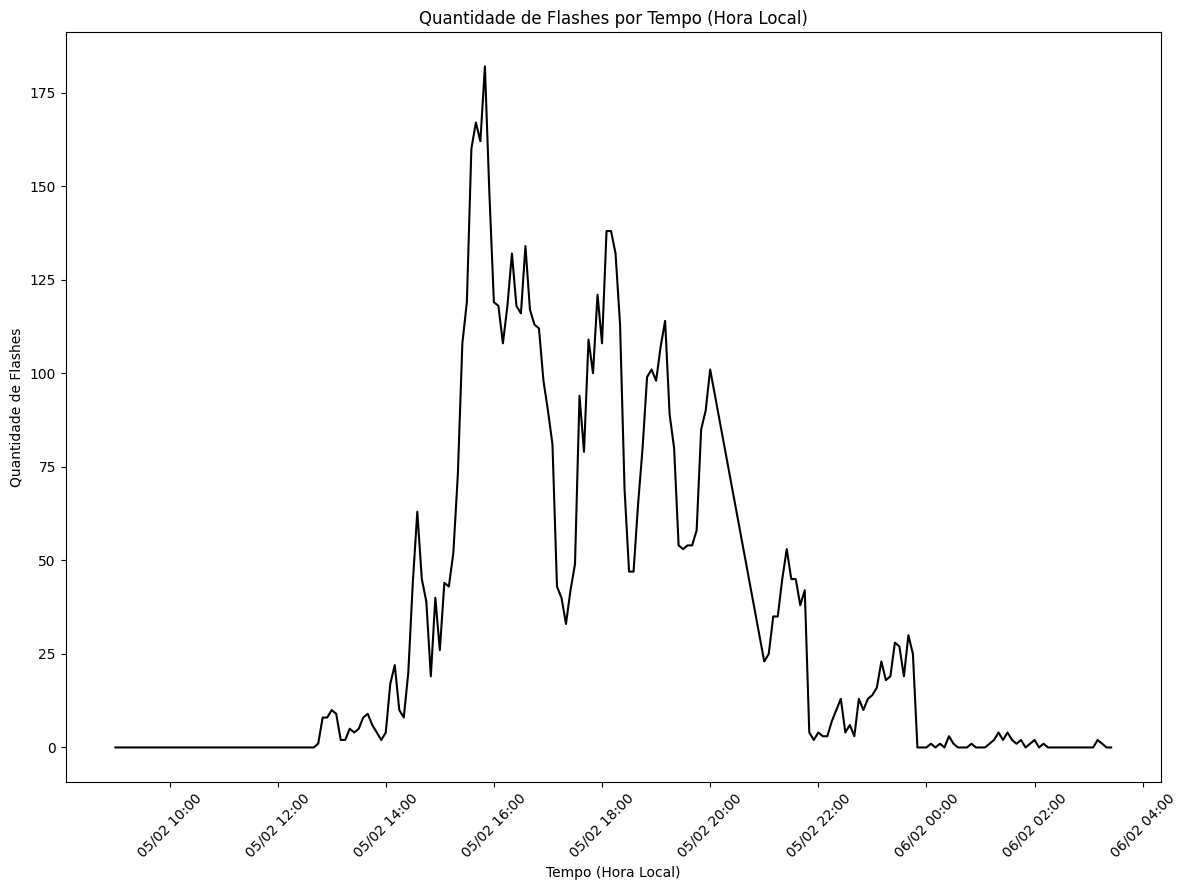

In [67]:
# Define o tempo de início e fim do plot
inicio = '2023-02-05 12:00:00'
fim = '2023-02-06 06:00:00'

# Converte as strings para objetos datetime
inicio_datetime = pd.to_datetime(inicio)
fim_datetime = pd.to_datetime(fim)

# Filtra os dados dentro do intervalo de tempo
flash_h_subset_filtered = flash_h_subset.sel(time=slice(inicio_datetime, fim_datetime))

# Extrair as datas filtradas
datas_filtradas = flash_h_subset_filtered['time'].values

# Subtrair o fuso horário (ex: UTC-3, portanto subtraímos 3 horas)
fuso_horario = pd.to_timedelta(-3, unit='h')
datas_filtradas_local = datas_filtradas + fuso_horario

# Contar o número de flashes em cada ponto de tempo filtrado
quantidade_flashes_filtradas = flash_h_subset_filtered[:,:].sum(dim=('lat', 'lon')).values

# Ordenar as datas e a quantidade de flashes
datas_filtradas_ordenadas = sorted(datas_filtradas_local)
quantidade_flashes_filtradas_ordenadas = [quantidade_flashes_filtradas[i] for i, data in enumerate(datas_filtradas_ordenadas)] #remove the nested loop

# Criar o gráfico
plt.figure(figsize=(12, 9))
plt.plot(datas_filtradas_ordenadas, quantidade_flashes_filtradas_ordenadas, linestyle='-', color='black')
plt.title('Flash/15min')
plt.xlabel('Local Time')
plt.ylabel('Quantidade de Flashes')

# Formatar o eixo x para exibir as horas locais
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m %H:%M'))
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

##Extrai em um xlsx(excel)
1.   Tempo e Quantidade
2.   Latitude/Longitude do ponto



In [70]:
df = pd.DataFrame({'Tempo': datas_filtradas_ordenadas, 'Quantidade de Flashes': quantidade_flashes_filtradas_ordenadas})

# Exportar o DataFrame para um arquivo xlsx
df.to_excel('/content/drive/My Drive/flashes.xlsx', index=False)

from google.colab import files

files.download('/content/drive/My Drive/caso01.xlsx')


FileNotFoundError: Cannot find file: /content/drive/My Drive/caso01.xlsx

In [ ]:
# Cria um DataFrame com as coordenadas dos flashes
df_coords = pd.DataFrame({'Latitude': flash_h_subset_filtered['lat'].values.flatten(),
                          'Longitude': flash_h_subset_filtered['lon'].values.flatten(),
                          'Tempo': np.repeat(flash_h_subset_filtered['time'].values, len(flash_h_subset_filtered['lat'].values))})

# Remove valores NaN
df_coords = df_coords.dropna()

# Exportar o DataFrame para um arquivo xlsx
df_coords.to_excel('/content/drive/My Drive/coordenadas_flashes.xlsx', index=False)

files.download('/content/drive/My Drive/coordenadas_flashes.xlsx')
